**1. 훈련 가이드라인**

바꿔보면 좋을 것들 (하이퍼파라미터)
1. learning_rate (기본은 0.001; 5배~ 10배씩 바꿔보는 거 추천)
2. scheduler 매개변수 gamma (기본: 에폭마다 0.9 배로 감소; 이건 감으로..)
3. batch size (기본: bs = 32; 한 번의 forward pass / backpropagation 마다 32 장의 이미지를 동시에 고려하는 것; 주의: bs 가 너무 작으면 학습이 안됨)
4. my_transforms 파라미터 (기본: Rescale(256)이고 700x700 을 256x256 으로 바꿔준다는 의미); transforms.Normalize( , ) 시도 해볼만 함
5. optimizer betas (기본: 0.5, 0.99)
6. model_name (기본: 'resnet34'; resnet18, resnet50, resnet101, resnet152 도 시도해볼만 함; 여기서 숫자 34,18, ... 은 layer depth를 의미)

TIP
- validation loss 를 봐야함.. training loss 가 줄어든다는 건 단순히 fitting 잘 된다는 것임
- MSE loss 기반이므로 loss 값 = (실제 좌표로부터의 픽셀 거리)^2 와 비슷함
- classification loss 가 줄어들 수록 분류 경계선을 잘 만들게 filter 가중치가 학습 되는 것이므로 regression 에도 어느 정도 좋은 영향을 주게 됨
- validation loss 의 변동(분산 또는 표준편차)이 크지 않아야 하고 test 이미지의 predicted 좌표의 변화 또한 크지 않을 수록 좋음 
- 데이터의 질과 양이 매우 중요하다.


** 중요: kw, additional_info 에서 지정한 이름으로 텐서보드 로그 / 모델checkpoint 가 생성됨


**2. 텐서보드 사용법**

1. 텐서보드 설치하기

2. cmd 열어서 다음을 입력: 

  cd 'runs' 폴더가 저장된 디렉토리 (runs 폴더를 다운로드 받은 위치)

  tensorboard --logdir=runs --samples_per_plugin=images=50

  예시)

  cd C:\Users\NormalKim\[0_BigData_Acu]\Acupuncture-Points\CV_DeepLearning

  tensorboard --logdir=runs --samples_per_plugin=images=50

  다음과 같은 창이 뜨면 성공임. 표시된 주소인 http://localhost:6006/ 으로 접속하여 결과를 확인하자. (주소는 바꿀 수 있음)


  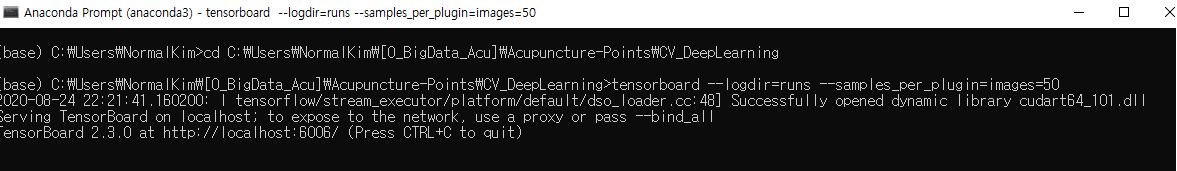



In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
os.chdir("/gdrive/Shared drives/고려대 빅데이터 13조/CV_Colab")

In [ ]:
os.listdir()

['main.py',
 'Training_utils.py',
 'Image_Process_utils.py',
 'arg_parser.py',
 'model_utils.py',
 'Dataset_utils.py',
 'tb_utils.py',
 'testdata',
 '__pycache__',
 'runs',
 'checkpoints',
 'Untitled0.ipynb']

In [ ]:
import Training_utils
import torchvision
from torchvision import transforms
import tb_utils
from tb_utils import *
from Training_utils import *
from Image_Process_utils import *
import model_utils
from model_utils import *
from Dataset_utils import *
import arg_parser
from arg_parser import common_arg_parser
from torch.utils.data import ConcatDataset

In [ ]:
my_transforms = transforms.Compose([
    #transforms.Normalize((0.5,), (0.5,)),
    Rescale(256), # 바꿔보자 
    Tensorize()
    ])

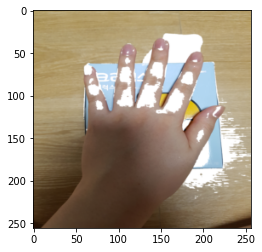

In [ ]:
# for creating test image list
test_imlist, target_imlist =  gen_test_img_list()
np_img = np.transpose( to_numpy(test_imlist[1]), (1,2,0))
plt.imshow(np_img)

In [ ]:
kw = 'sobu'
additional_info = 'org+rot+fill+rotfill' # 각자 정하는 키워드 (설정한 하이퍼파라미터가 좋긴 함)

In [ ]:
global t_step
global v_step
global test_step
global micro_step
global v_micro

In [ ]:
t_step = v_step = test_step = micro_step = v_micro = 0
arg_parser =common_arg_parser()
args, unknown_args = arg_parser.parse_known_args()

In [ ]:
os.listdir('../Augmented')

['sobu',
 'urjae',
 'hapgok',
 'shinmoon',
 'nogung',
 'sochung',
 'sangyang',
 'taeyeon',
 'sotack',
 'hugye',
 'gwanchung']

In [ ]:
def create_dataset(kw, augtype = 'filled'):
    if augtype == 'org':
        img_dir = '../Augmented/' + kw + '/org' 
        json_file = f'../Augmented/{kw}/{kw}_info.json' 
        return HandDataSet(json_file, img_dir, transform = my_transforms, train=True, hand_flag=True)
    elif augtype in ['filled', 'rotated', 'rotated_filled']:
        img_dir = f'../Augmented/{kw}/{augtype}/{augtype}' 
        json_file = f'../Augmented/{kw}/{augtype}/{kw}_{augtype}.json' 
        return HandDataSet(json_file, img_dir, transform = my_transforms, train=True) 
    else:
        pass

In [ ]:
# data filled
d1= create_dataset(kw, augtype = 'filled')
# data rotated
d2= create_dataset(kw, augtype = 'rotated')
# data rotated-filled
d3= create_dataset(kw, augtype = 'rotated_filled')
# data original
d4= create_dataset(kw, augtype = 'org')
concat_dataset = ConcatDataset([d1, d2, d3, d4])

set()
set()
set()
set()


In [ ]:
bs = 32 # 바꿔보자 

In [ ]:
test_set_size = int(len(concat_dataset) * 0.01) # 
train_set_size = len(concat_dataset) - test_set_size
train_set, test_set = torch.utils.data.random_split(concat_dataset, [train_set_size, test_set_size])
valid_set_size = int((train_set_size)*0.1) 
train_set_size = train_set_size - valid_set_size
train_set, valid_set  = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size])
train_set_size, valid_set_size, test_set_size
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True, num_workers=1)
valid_loader = DataLoader(valid_set, batch_size = bs, shuffle = True, num_workers=1)
test_loader = DataLoader(test_set, batch_size = bs, shuffle = True, num_workers=1)


In [ ]:
train_set_size, valid_set_size, test_set_size

(192, 21, 21071)

In [ ]:
model_name = 'resnet50' # 바꿔보자 
model = create_model(model_name)

In [ ]:
#!pip install torchsummary
#from torchsummary import summary
#summary(model.to('cuda'), input_size = (3, 700, 700))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device) # cuda:0 뜨면 gpu 

device:  cuda:0


In [ ]:
model.to(device) # model gpu 로 바꿔주자 

MyResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [ ]:
best_val = 100000000
learning_rate = 0.001 # 바꿔보자
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999)) # 바꿔보자
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.9) # 바꿔보자 
class_loss = class_loss()
coord_loss = coord_loss()
today = str(datetime.datetime.now().today())
time_info = today[5:7] +today[8:10] + '_' + today[11:13] + today[14:16]
args.prefix = kw + time_info + additional_info
args.epochs = 100 # 전체 에폭 
writer = SummaryWriter('runs/'+args.prefix)

In [ ]:
for epoch in range(args.start_epoch, args.epochs):
    tr_loss, micro_step, t_step =  train(model, train_loader, optimizer, coord_loss, class_loss, epoch, writer, micro_step, t_step)
    val_loss, v_micro, v_step = validate(model, valid_loader, coord_loss, class_loss, epoch, writer, v_micro, v_step)
    test_step = test(test_imlist, target_imlist, model, writer, 'test_image', test_step)
    writer.flush()
    
    val_loss
    is_best = sum(val_loss[0:2]) < best_val
    best_val = min( sum(val_loss[0:2]), best_val )
    
    save_checkpoint({
        'epoch' : epoch,
        'model' : args.model, 
        'state_dict' : model.state_dict(),
        'best_val' : best_val, 
        'optimizer' : optimizer.state_dict(),
        'scheduler' : scheduler.state_dict()
    }, is_best, args.prefix)

writing test img with step 0
writing test img with step 1


In [ ]:
# checkpoint 폴더에 있는 파일명을 넣으면 해당 지점부터 train 다시 시작함

args.resume = './checkpoints/sobu0825_1434org+rot+fill+rotfill_checkpoint.pth.tar'

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_val = checkpoint['best_val']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

=> loading checkpoint './checkpoints/sobu0825_1434org+rot+fill+rotfill_checkpoint.pth.tar'
=> loaded checkpoint './checkpoints/sobu0825_1434org+rot+fill+rotfill_checkpoint.pth.tar' (epoch 1)


57.6389 56.47818


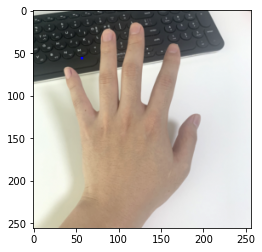

In [ ]:
# testdata 폴더에 이미지 넣고 직접 테스트 해보는 것도 가능 
# 이때 모델이 훈련한 사이즈로 resize 해줘야 함 (기본:256)

i = 1

dir1 = './testdata/test' + str(i) + '.jpg'
img = Image.open(dir1)
img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = 256),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))

img2 = clear_background(cv2.imread(dir1))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img2)
img2 = transform(im_pil)

_, out2 = model(img2.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))